In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
import mudata
from sklearn.linear_model import LinearRegression
import functools

import os
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax
fsize = 13
plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
# make atac vs rna for subsampled data dig

base = "/home/sina/projects/cellatlas/data/dogmaseq-dig"

rna_path = os.path.join(base, "rna_subsam/counts_unfiltered/adata.h5ad")
atac_path = os.path.join(base, "atac_subsam/counts_mult/adata.h5ad")
rna_onlist = os.path.join(base, "RNA-737K-arc-v1.txt")
atac_onlist = os.path.join(base, "ATA-737K-arc-v1_rc.txt")

rna = anndata.read_h5ad(rna_path)
atac = anndata.read_h5ad(atac_path)

# map between the atac barcodes and the rna barcodes
gwl = pd.read_csv(rna_onlist, header=None, names=["rna"]) # 10x_version3_whitelist.txt
awl = pd.read_csv(atac_onlist, header=None, names=["ata"]) # 737K-arc-v1_rc.txt

# Map BCs between RNA and ATAC
bcmap = pd.concat([awl, gwl], axis=1).set_index("ata")

atac.obs["ata_bcs"] = atac.obs.index.values
atac.obs["rna_bcs"] = atac.obs.index.map(bcmap["rna"])
atac.obs.set_index("rna_bcs", inplace=True)

common = np.intersect1d(rna.obs.index.values, atac.obs.index.values)

rna = rna[common].copy()
rna.obs = mx_inspect_rows(rna.X.copy(), rna.obs.index.values).copy()
rna.var = mx_inspect_cols(rna.X.copy(), rna.var.index.values).copy()

atac = atac[common].copy()
atac.obs = mx_inspect_rows(atac.X.copy(), atac.obs.index.values).copy()
atac.var = mx_inspect_cols(atac.X.copy(), atac.var.index.values).copy()


m = mudata.MuData({
    "rna": rna, 
    "atac": atac
})

In [4]:
m

MuData object with n_obs × n_vars = 560338 × 131145
  var:	'counts_min', 'counts_max', 'counts_sum', 'counts_mean', 'counts_nnzero', 'counts_variance'
  2 modalities
    rna:	560338 x 62754
      obs:	'counts_min', 'counts_max', 'counts_sum', 'counts_mean', 'counts_nnzero', 'counts_variance'
      var:	'counts_min', 'counts_max', 'counts_sum', 'counts_mean', 'counts_nnzero', 'counts_variance'
    atac:	560338 x 68391
      obs:	'counts_min', 'counts_max', 'counts_sum', 'counts_mean', 'counts_nnzero', 'counts_variance'
      var:	'counts_min', 'counts_max', 'counts_sum', 'counts_mean', 'counts_nnzero', 'counts_variance'

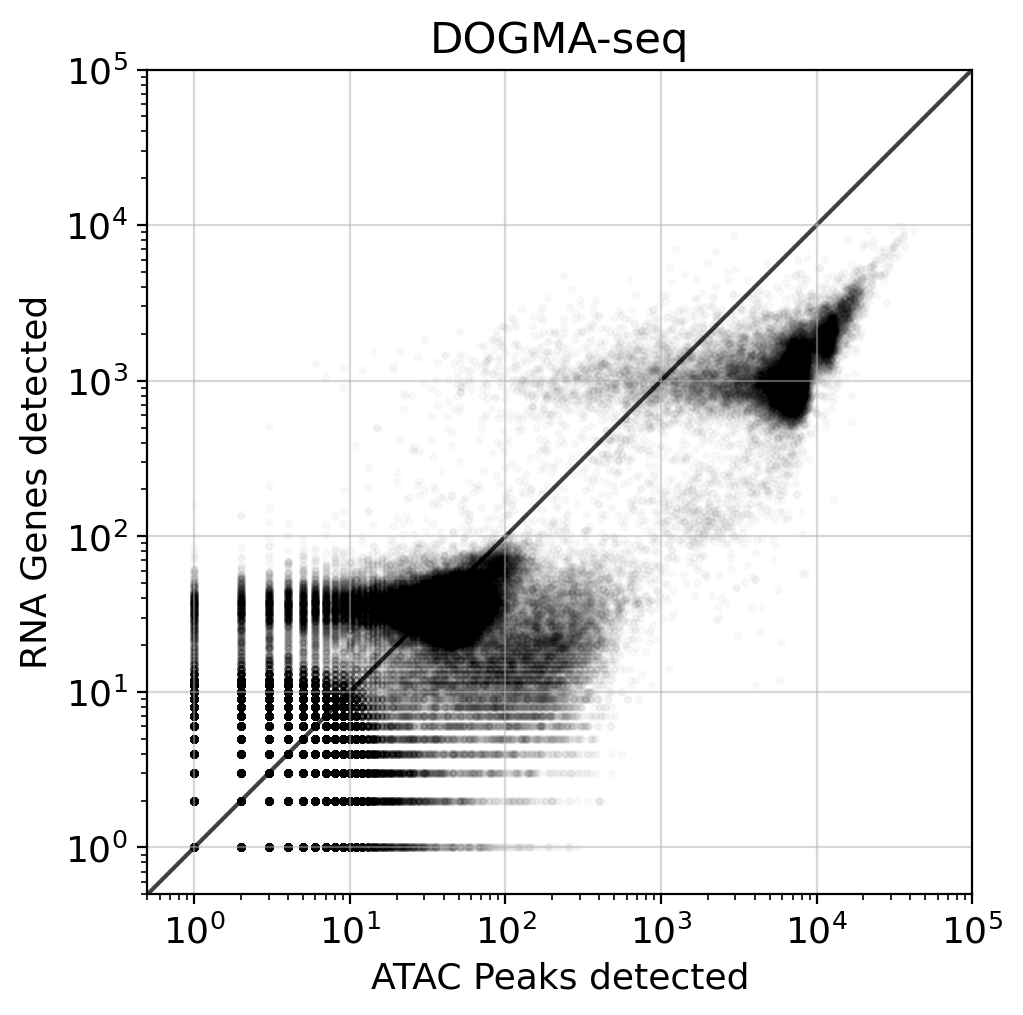

In [25]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

x = m.obs["atac:counts_nnzero"]
y = m.obs["rna:counts_nnzero"]

ax.scatter(x,y, s=5, color="k", alpha=0.02)

# xx = np.arange(x.min(), x.max())
# y = -xx + 1000
# ax.plot(xx, y, color="k", linestyle="dotted")

ax.set(**{
    "title": "DOGMA-seq",
    "xlabel": "ATAC Peaks detected",
    "ylabel": "RNA Genes detected",
    "xscale": "log",
    "yscale": "log",
    "xlim": (0.5, 1e5),
    "ylim": (0.5, 1e5)
})
yex(ax)
ax.grid(alpha=0.5)
fig.savefig("dogmaseq.png", bbox_inches="tight", dpi=300)
fig.show()

In [16]:
((m.obs["rna:counts_sum"] + m.obs["atac:counts_sum"]) > 1000).sum()

19952